In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor




In [12]:
df = pd.read_csv("data/india_housing_prices.csv")
df.head()

,State,City,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,...,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,ID
0,Uttarakhand,Dehradun,Apartment,3,1454,94.77,0.06518,2015,Furnished,2,...,1,5,Medium,Yes,Yes,Garden,West,Broker,Ready_to_Move,1
1,Uttarakhand,Dehradun,Apartment,2,1374,80.50,0.05859,2019,Unfurnished,3,...,4,3,Medium,Yes,Yes,"Gym, Playground",South,Owner,Under_Construction,2
2,Uttarakhand,Dehradun,Apartment,1,1152,76.63,0.06652,2019,Unfurnished,1,...,5,3,High,No,Yes,"Gym, Playground, Clubhouse",West,Builder,Ready_to_Move,3
3,Uttarakhand,Dehradun,Apartment,4,1038,57.81,0.05569,2022,Semi-furnished,2,...,2,3,High,Yes,Yes,"Garden, Playground, Pool",South,Builder,Ready_to_Move,4
4,Uttarakhand,Dehradun,Apartment,1,1501,82.09,0.05469,2017,Semi-furnished,3,...,5,3,Low,No,No,"Pool, Garden, Playground",West,Owner,Under_Construction,5


## EDA

------------ No missing values ------------

In [13]:
df.isnull().sum()

State                             0
City                              0
Property_Type                     0
BHK                               0
Size_in_SqFt                      0
Price_in_Lakhs                    0
Price_per_SqFt                    0
Year_Built                        0
Furnished_Status                  0
Floor_No                          0
Total_Floors                      0
Age_of_Property                   0
Nearby_Schools                    0
Nearby_Hospitals                  0
Public_Transport_Accessibility    0
Parking_Space                     0
Security                          0
Amenities                         0
Facing                            0
Owner_Type                        0
Availability_Status               0
ID                                0
dtype: int64

In [14]:
df.dtypes

State                              object
City                               object
Property_Type                      object
BHK                                 int64
Size_in_SqFt                        int64
Price_in_Lakhs                    float64
Price_per_SqFt                    float64
Year_Built                          int64
Furnished_Status                   object
Floor_No                            int64
Total_Floors                        int64
Age_of_Property                     int64
Nearby_Schools                      int64
Nearby_Hospitals                    int64
Public_Transport_Accessibility     object
Parking_Space                      object
Security                           object
Amenities                          object
Facing                             object
Owner_Type                         object
Availability_Status                object
ID                                  int64
dtype: object

- **BHK** stands for Bedroom, Hall, and Kitchen. It's a common term in the Indian real estate market used to describe the configuration of a residential property. 
    - **Example:** 1 BHK: One bedroom, one hall, and one kitchen

In [15]:
df.describe()

,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,ID
count,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000
mean,2.507123,1690.289308,69.646334,0.041330,2016.987031,3.505062,5.976538,5.513692,2.994415,2.994785,32500.500000
std,1.116836,543.425106,28.609807,0.010126,3.163450,1.703351,2.579075,2.877269,1.414360,1.415460,18764.028086
min,1.000000,800.000000,20.390000,0.025000,2012.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1293.000000,49.130000,0.033050,2014.000000,2.000000,4.000000,3.000000,2.000000,2.000000,16250.750000
50%,3.000000,1572.000000,63.370000,0.040900,2017.000000,4.000000,6.000000,6.000000,3.000000,3.000000,32500.500000
75%,4.000000,1974.250000,83.170000,0.048000,2020.000000,5.000000,8.000000,8.000000,4.000000,4.000000,48750.250000
max,4.000000,3000.000000,207.190000,0.070000,2022.000000,6.000000,10.000000,10.000000,5.000000,5.000000,65000.000000


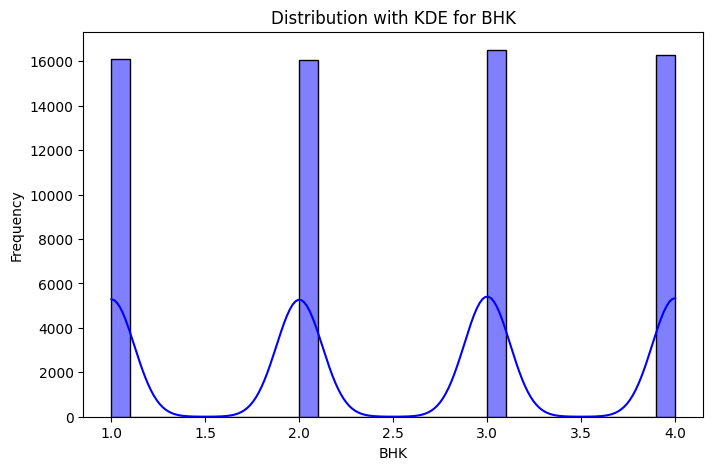

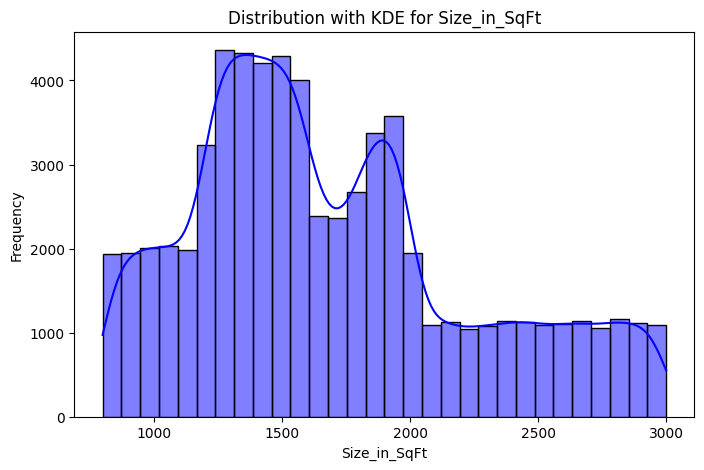

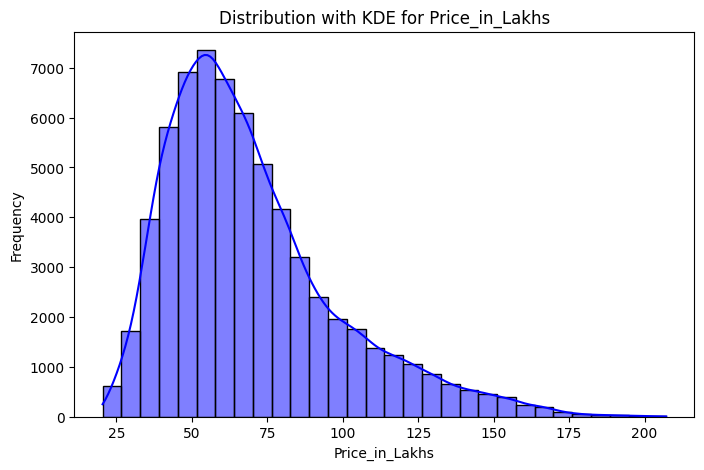

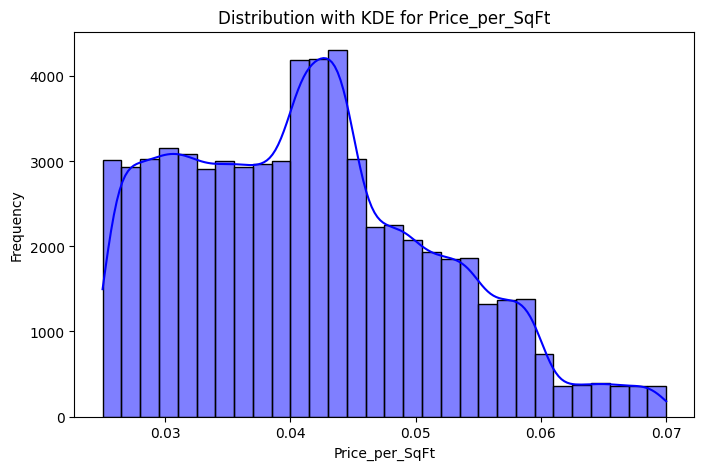

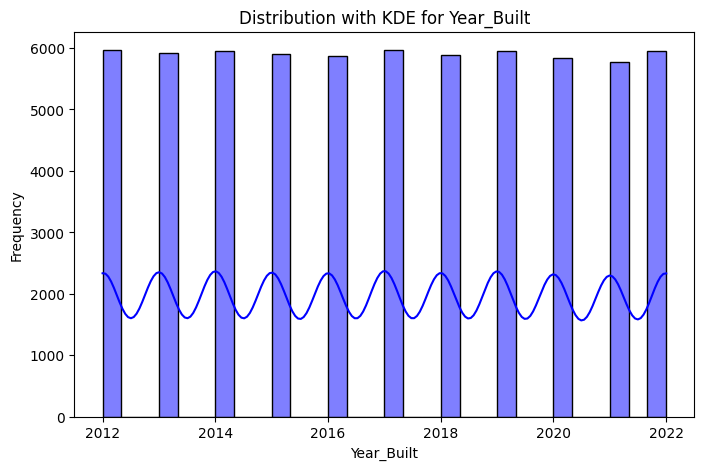

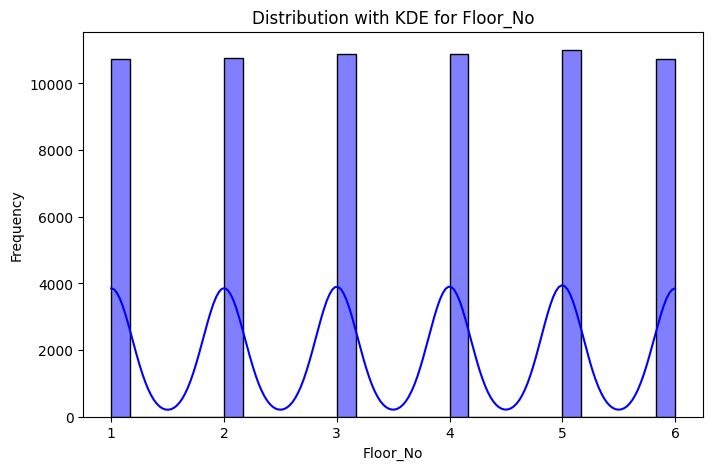

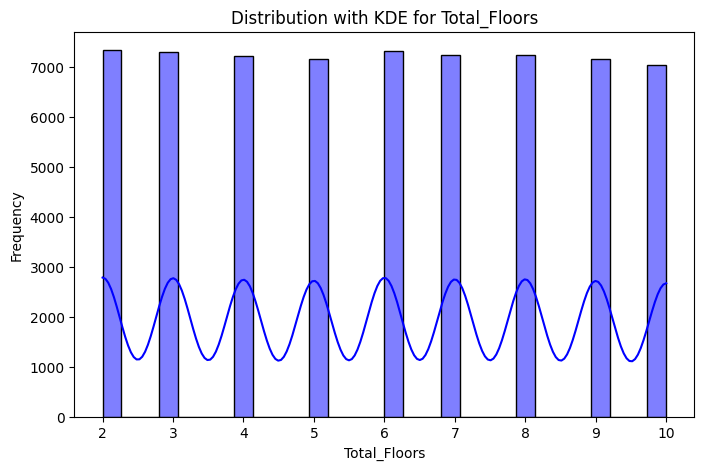

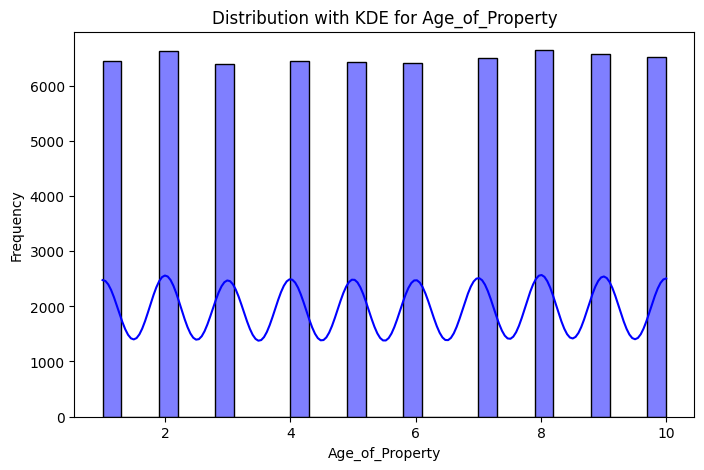

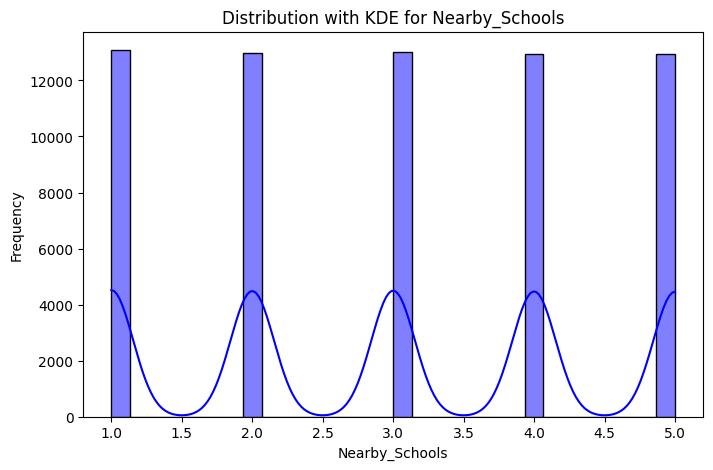

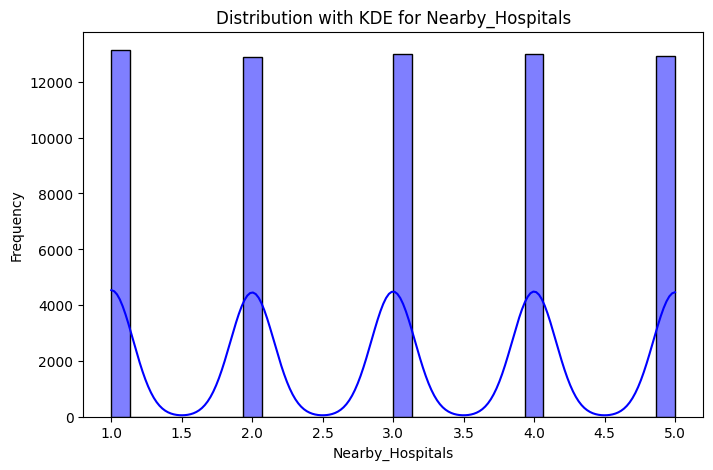

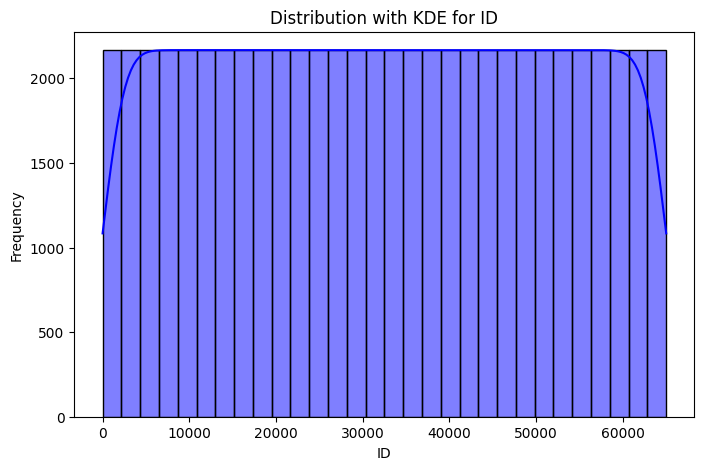

In [16]:
numerical_col = [column for column in df.columns if df[column].dtype != 'object'] # seperated numerical columns

for col in numerical_col:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution with KDE for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


## Pre-Processing

### ------------ Dropping `ID` column since it's irrelevant ------------ 

In [17]:
df.drop('ID', axis=1, inplace=True)

### ------------ Dropping `Locality` column since it's doesn't containg meaningful address ------------ 

### ------------ Using Ordinal Encoder to Encode Ordinal Values -------------

In [18]:
ordinal_columns = ['Property_Type', 'Furnished_Status', 'Public_Transport_Accessibility', 'Facing', 'Security']

categories = [['Apartment', 'Independent House', 'Villa'],
              ['Unfurnished', 'Semi-furnished', 'Furnished'],
              ['Low', 'Medium', 'High'],
              ['South', 'East', 'West', 'North'],  # In India, west facing and north facing properties are more valuable
              ['No', 'Yes']]

encoder = OrdinalEncoder(categories=categories)
df[ordinal_columns] = encoder.fit_transform(df[ordinal_columns])

### ------------ Separating Categorical and Numerical columns --------------

In [19]:
categorical_col = [column for column in df.columns if df[column].dtype == 'object']
numerical_col = [column for column in df.columns if df[column].dtype != 'object']

In [20]:
len(categorical_col), len(numerical_col)

(6, 15)

### ------------ Lower cap strings for better accessibility --------------

In [21]:
for column in categorical_col:
    df[column] = df[column].str.lower()

### ------------ Checking Correlation ------------

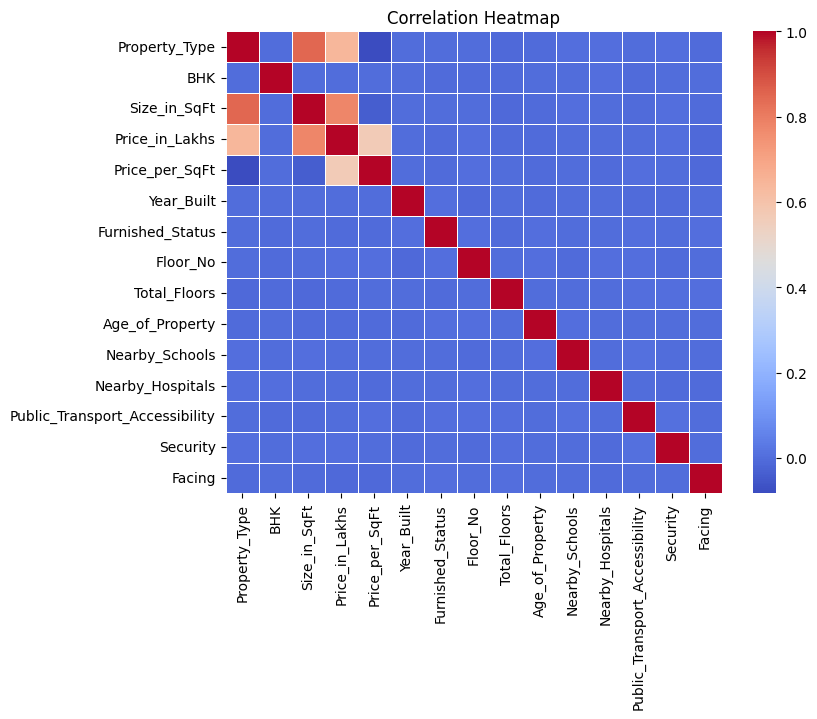

In [22]:
correlation_matrix = df[numerical_col].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### ------------ Splitting Dataset and Picking Out Smaller Sample ------------

---------------  Reducing **Number of rows** to speed up training due to low compute power -----------

In [23]:
# Randomly sample 40% of the data
df_sampled = df.sample(frac=0.4, random_state=1)

In [24]:
df_sampled

,State,City,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
15099,uttarakhand,nainital,0.0,3,1071,62.33,0.05820,2017,2.0,6,...,5,5,2,1.0,no,1.0,garden,1.0,builder,under_construction
51459,uttarakhand,tehri,0.0,4,933,24.27,0.02601,2017,1.0,3,...,8,2,5,2.0,no,0.0,"playground, gym",0.0,builder,ready_to_move
33751,uttarakhand,pauri,1.0,4,1265,53.84,0.04256,2020,0.0,5,...,6,4,2,0.0,yes,0.0,pool,2.0,owner,under_construction
23098,uttarakhand,almora,1.0,3,1228,54.45,0.04434,2016,1.0,1,...,7,2,2,0.0,yes,1.0,"playground, garden, gym",0.0,builder,ready_to_move
37351,uttarakhand,champawat,1.0,4,1286,50.27,0.03909,2013,1.0,6,...,8,4,5,1.0,yes,0.0,"clubhouse, gym",0.0,builder,ready_to_move
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,uttarakhand,tehri,1.0,2,1516,67.36,0.04443,2019,0.0,3,...,2,1,2,2.0,yes,0.0,"clubhouse, pool, garden",3.0,builder,under_construction
34598,uttarakhand,pauri,2.0,2,2946,78.54,0.02666,2018,0.0,4,...,7,5,5,0.0,yes,1.0,"playground, pool, garden",2.0,builder,under_construction
3434,uttarakhand,dehradun,1.0,2,1806,103.61,0.05737,2019,2.0,3,...,4,3,3,1.0,no,1.0,"clubhouse, pool, garden",0.0,builder,under_construction
21144,uttarakhand,almora,1.0,2,1719,62.18,0.03617,2018,2.0,1,...,2,2,3,2.0,no,1.0,garden,0.0,builder,under_construction


In [25]:
X = df_sampled.drop('Price_in_Lakhs', axis=1)  
y = df_sampled['Price_in_Lakhs']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [26]:
len(X_test), len(X_train)

(5200, 20800)

### ------------ Encoding Categorical Variables ------------
- DictVectorizer automatically handles categorical columns

In [27]:
train_dicts = X_train.to_dict(orient='records') # using resampled data as our train feature
test_dicts = X_test.to_dict(orient='records')

In [28]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)

## Training The Model
- Training Using Different Models and Evaluating Their Results
- Helper function and list to evaluate models and store scores

In [29]:
model_results = []

def evaluate_model(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    return mae, mse, rmse, r2

In [30]:
# model_results.append({
#     "Model": "Linear Regression",
#     "MAE": mae,
#     "MSE": mse,
#     "RMSE": rmse,
#     "R2": R2
# })

## Linear Regression

In [31]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [32]:
y_pred = model.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2

(3.728996194696073, 31.048005920441167, 5.572073754038183, 0.9624824015287583)

In [33]:
model_results.append({
    "Model": "Linear Regression",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

### Decision Tree
- Tuning Parameter

In [34]:
scores = []

for i in range(1, 12):
    for min_sample_leaf_values in [1, 3, 4, 5, 6, 8, 10, 15]:
        dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_sample_leaf_values, random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)

        scores.append((i, min_sample_leaf_values, mae, mse, rmse, r2))

In [35]:
df_scores = pd.DataFrame(scores, columns=['depth', 'leaf', 'mae', 'mse', 'rmse', 'r2'])

In [36]:
df_scores

,depth,leaf,mae,mse,rmse,r2
0,1,1,16.780007,452.075613,21.262070,0.453724
1,1,3,16.780007,452.075613,21.262070,0.453724
2,1,4,16.780007,452.075613,21.262070,0.453724
3,1,5,16.780007,452.075613,21.262070,0.453724
4,1,6,16.780007,452.075613,21.262070,0.453724
...,...,...,...,...,...,...
83,11,5,0.765870,1.123686,1.060041,0.998642
84,11,6,0.770984,1.124053,1.060214,0.998642
85,11,8,0.805493,1.296649,1.138705,0.998433
86,11,10,0.841262,1.472477,1.213457,0.998221


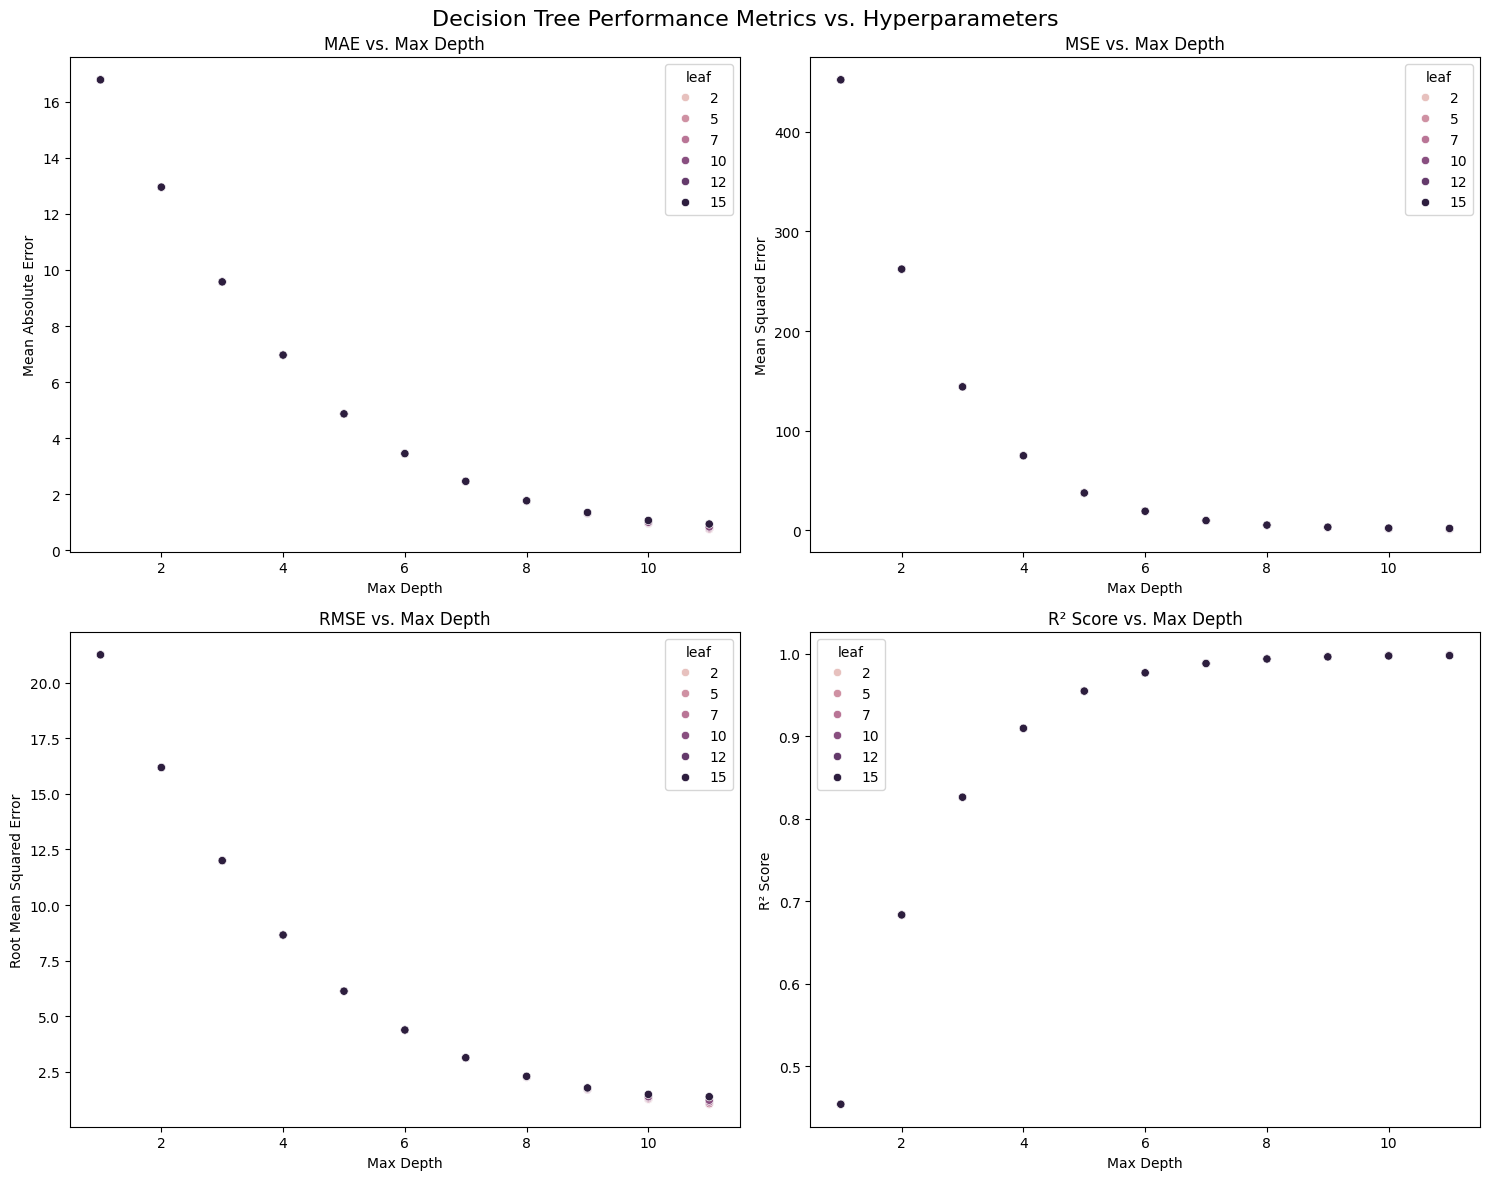


Best Parameters for different metrics:

Best parameters for minimum MAE:
depth    11.000000
leaf      4.000000
mae       0.757251
mse       1.067053
rmse      1.032983
r2        0.998711
Name: 82, dtype: float64

Best parameters for minimum MSE:
depth    11.000000
leaf      4.000000
mae       0.757251
mse       1.067053
rmse      1.032983
r2        0.998711
Name: 82, dtype: float64

Best parameters for minimum RMSE:
depth    11.000000
leaf      4.000000
mae       0.757251
mse       1.067053
rmse      1.032983
r2        0.998711
Name: 82, dtype: float64

Best parameters for maximum R2:
depth    11.000000
leaf      4.000000
mae       0.757251
mse       1.067053
rmse      1.032983
r2        0.998711
Name: 82, dtype: float64


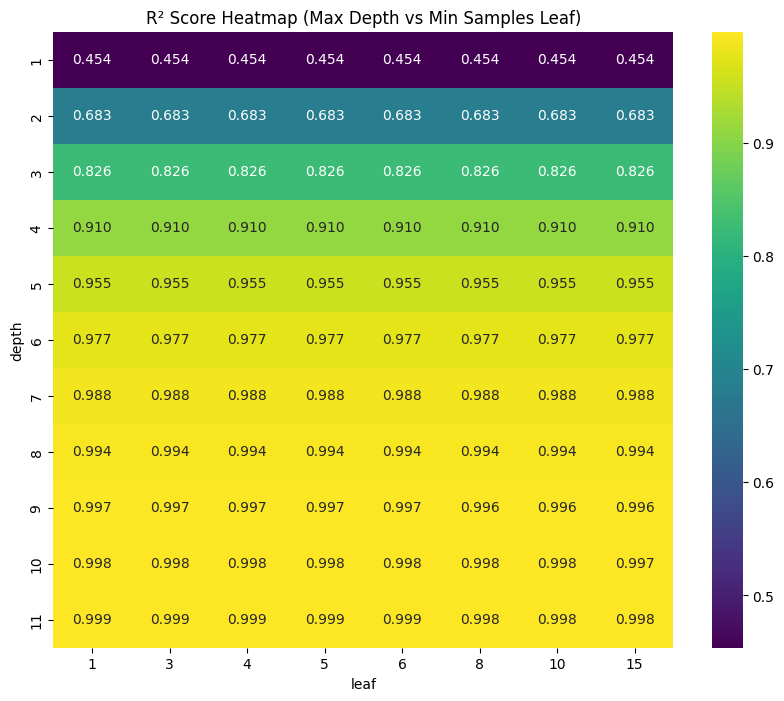

In [37]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Tree Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='depth', y='mae', hue='leaf', ax=axes[0,0])
axes[0,0].set_title('MAE vs. Max Depth')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='depth', y='mse', hue='leaf', ax=axes[0,1])
axes[0,1].set_title('MSE vs. Max Depth')
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='rmse', hue='leaf', ax=axes[1,0])
axes[1,0].set_title('RMSE vs. Max Depth')
axes[1,0].set_xlabel('Max Depth')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='r2', hue='leaf', ax=axes[1,1])
axes[1,1].set_title('R² Score vs. Max Depth')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

# Find the best parameters based on different metrics
print("\nBest Parameters for different metrics:")
print("\nBest parameters for minimum MAE:")
print(df_scores.loc[df_scores['mae'].idxmin()])

print("\nBest parameters for minimum MSE:")
print(df_scores.loc[df_scores['mse'].idxmin()])

print("\nBest parameters for minimum RMSE:")
print(df_scores.loc[df_scores['rmse'].idxmin()])

print("\nBest parameters for maximum R2:")
print(df_scores.loc[df_scores['r2'].idxmax()])

# Create a heatmap for R2 scores
plt.figure(figsize=(10, 8))
pivot_table = df_scores.pivot(index='depth', columns='leaf', values='r2')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('R² Score Heatmap (Max Depth vs Min Samples Leaf)')
plt.show()

Choosing Leaf = 15 and depth = 20 since the scores are improving as depth increases

In [38]:
dt = DecisionTreeRegressor(max_depth=20, min_samples_leaf=15, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

(0.9221029448314109, 1.8443212976780128, 1.3580579139631759, 0.997771370371561)

In [39]:
model_results.append({
    "Model": "Decision Tree",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

### Random Forest

In [40]:
rf = RandomForestRegressor(random_state=1, n_jobs=-1, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

(4.593926346153846, 37.4109402949923, 6.116448339926718, 0.9547935980167073)

------- Tuning N_estimator -----------

In [41]:
scores = []

for n in range(10, 301, 40): # going to 200 with 40 steps
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1, max_features='sqrt')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
    mae, mse, rmse, r2 
    scores.append((n, mae, mse, rmse, r2))

In [42]:
df_scores = pd.DataFrame(scores, columns=['n_estimator', 'mae', 'mse', 'rmse', 'r2'])

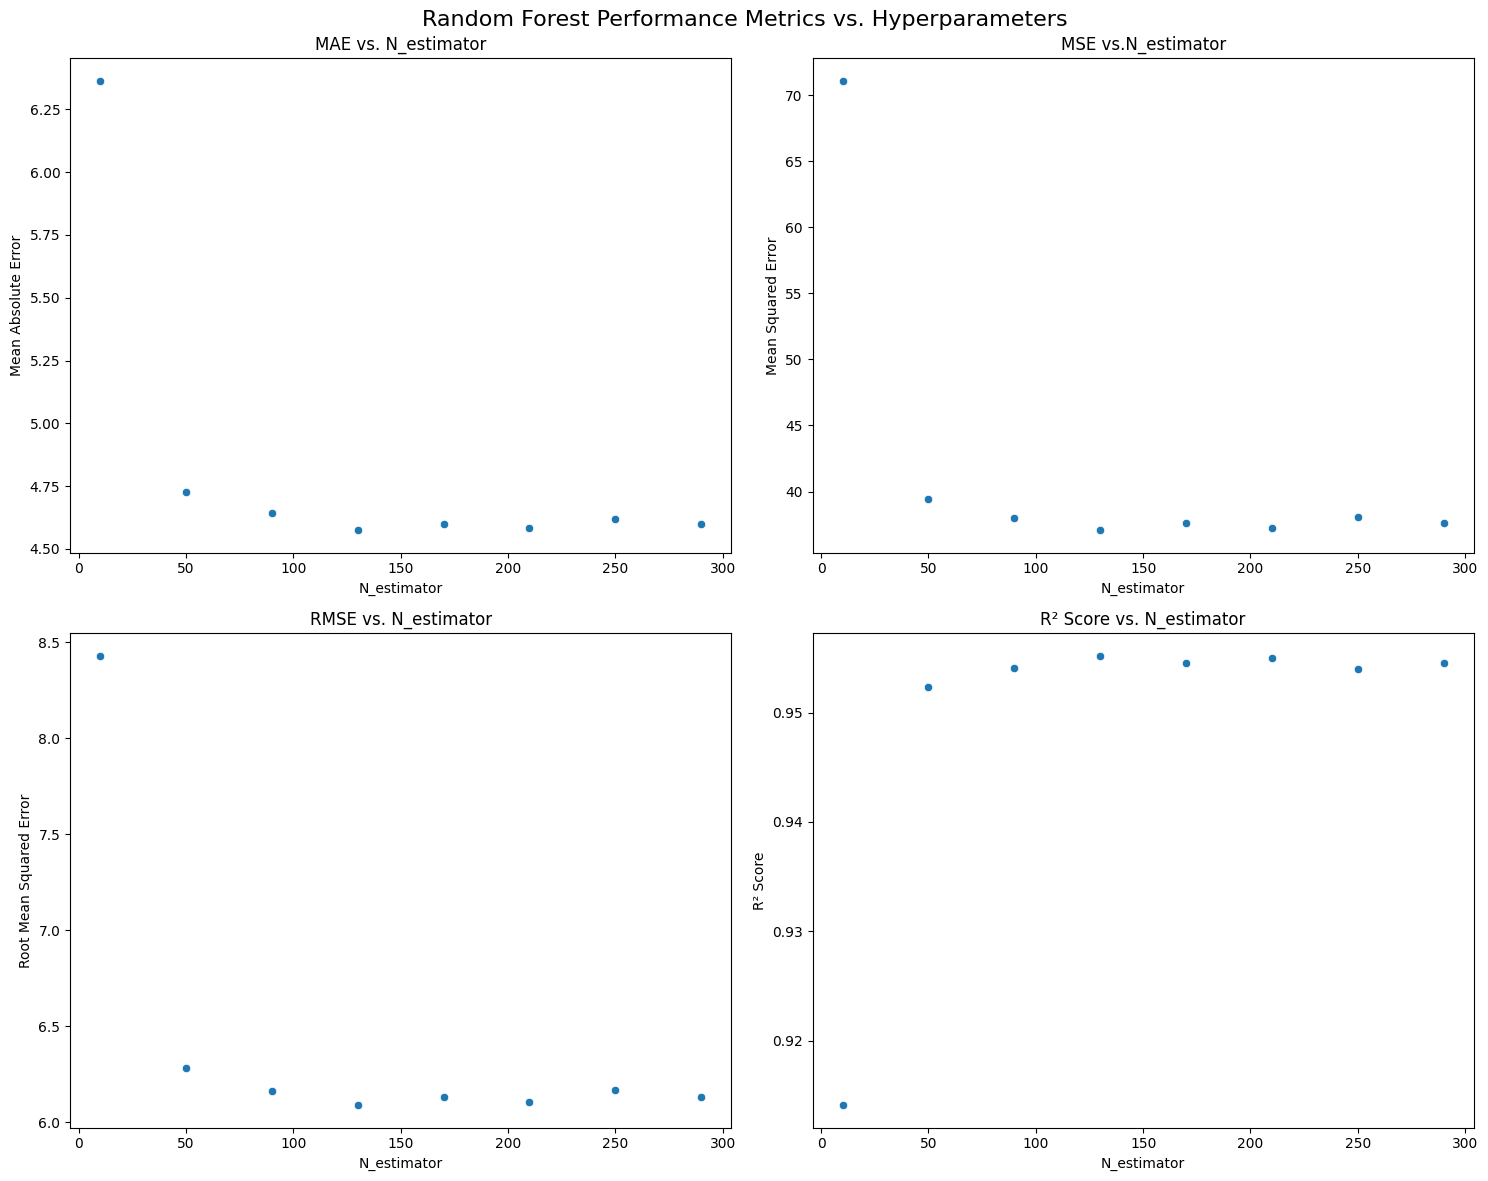

In [43]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='n_estimator', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. N_estimator')
axes[0,0].set_xlabel('N_estimator')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.N_estimator')
axes[0,1].set_xlabel('N_estimator')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. N_estimator')
axes[1,0].set_xlabel('N_estimator')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. N_estimator')
axes[1,1].set_xlabel('N_estimator')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()


100 n_estimators

--------- Tuning depths ----------

In [44]:
scores = []

for d in [1, 3, 5, 10, 20, 25, 35, 50]: # tuning depths
    rf = RandomForestRegressor(max_depth=d ,n_estimators=100, random_state=1, n_jobs=-1, 
                               max_features='sqrt', verbose=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
    mae, mse, rmse, r2 
    scores.append((d, mae, mse, rmse, r2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parall

In [45]:
df_scores = pd.DataFrame(scores, columns=['depth', 'mae', 'mse', 'rmse', 'r2'])

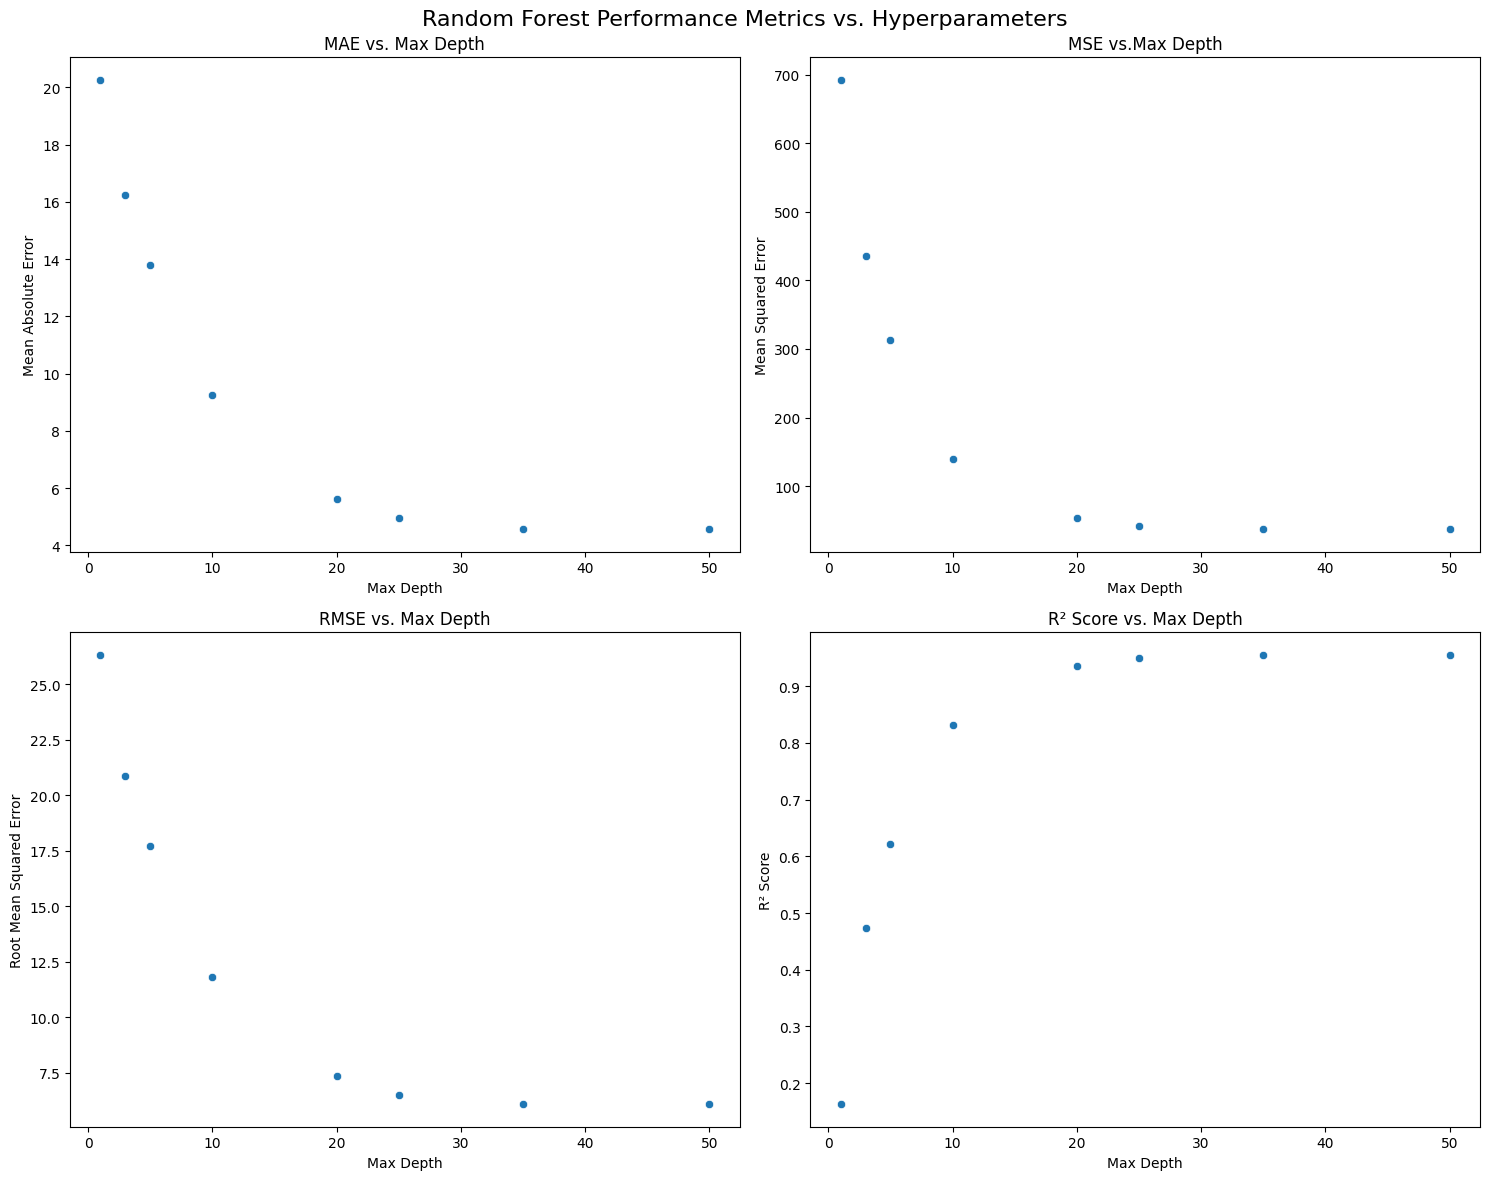

In [46]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='depth', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. Max Depth')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='depth', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.Max Depth')
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. Max Depth')
axes[1,0].set_xlabel('Max Depth')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. Max Depth')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()


------------ Taking max_depth 50 and tuning min_sample_leaf ---------

In [47]:
scores = []

for s in [1, 3, 5, 10, 20, 35]: # tuning depths
    rf = RandomForestRegressor(max_depth=50 ,n_estimators=100, min_samples_leaf=s, random_state=1, n_jobs=-1, 
                               max_features='sqrt', verbose=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
    mae, mse, rmse, r2 
    scores.append((s, mae, mse, rmse, r2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parall

In [48]:
df_scores = pd.DataFrame(scores, columns=['leaf', 'mae', 'mse', 'rmse', 'r2'])

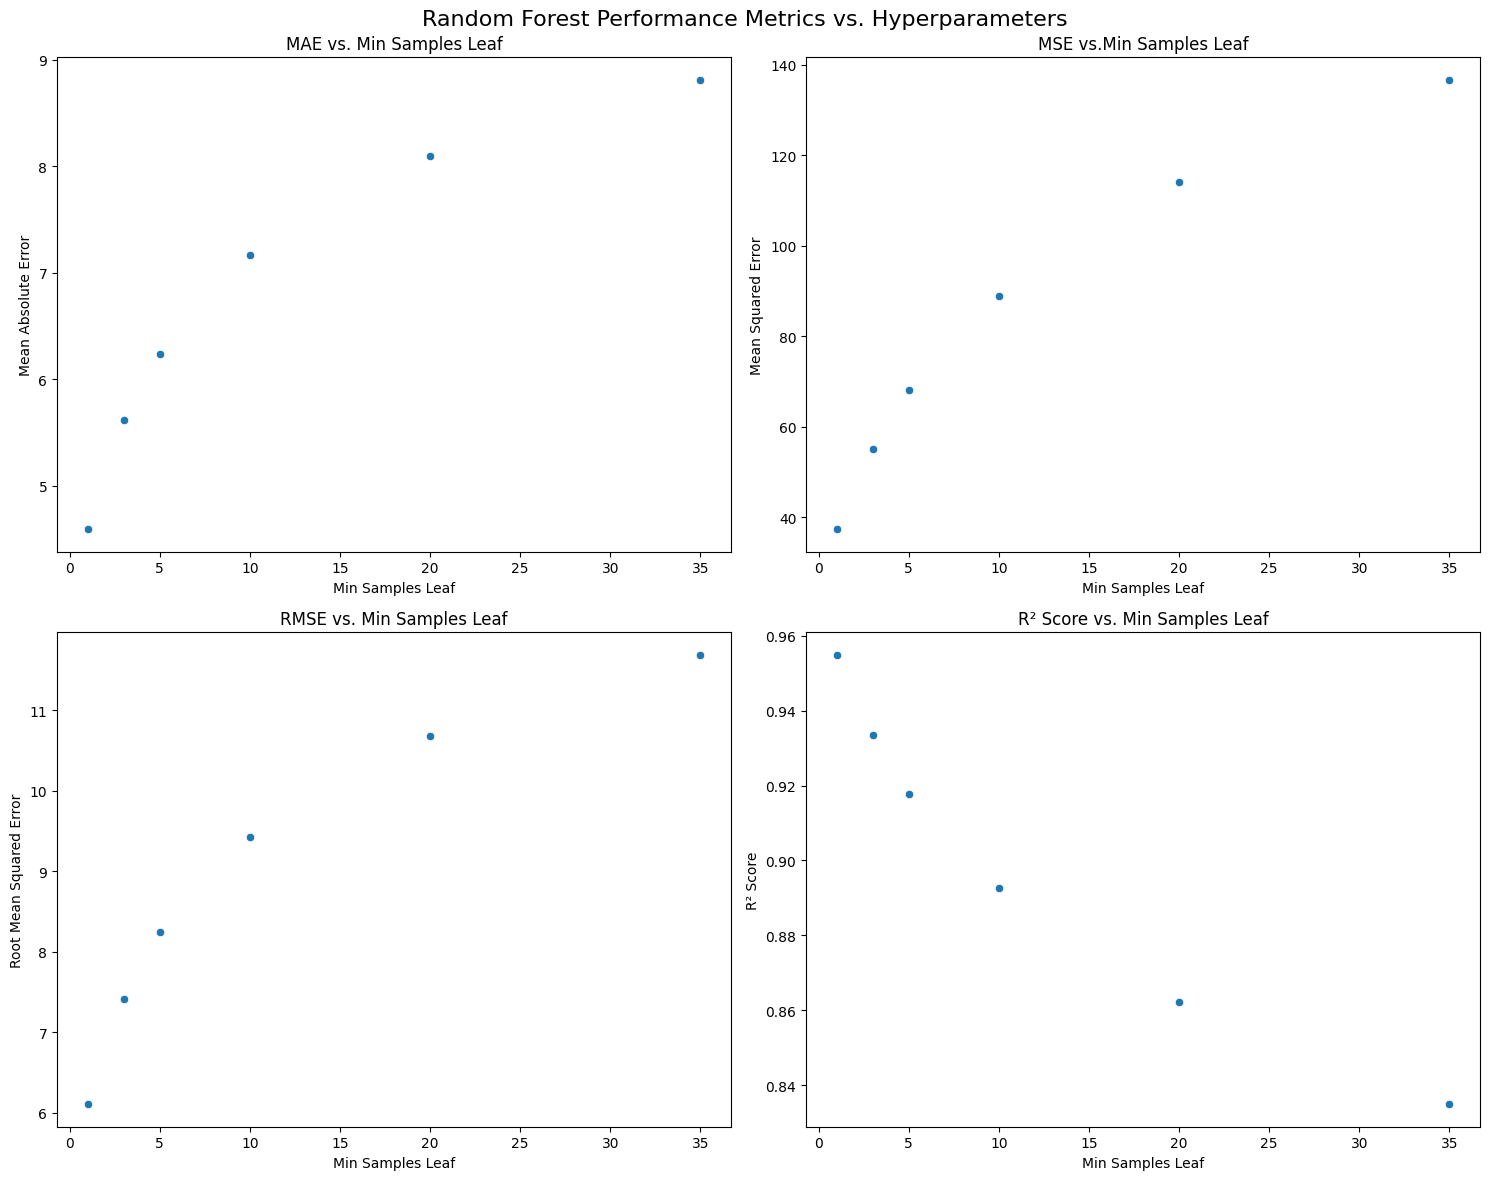

In [49]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='leaf', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. Min Samples Leaf')
axes[0,0].set_xlabel('Min Samples Leaf')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='leaf', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.Min Samples Leaf')
axes[0,1].set_xlabel('Min Samples Leaf')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='leaf', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. Min Samples Leaf')
axes[1,0].set_xlabel('Min Samples Leaf')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='leaf', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. Min Samples Leaf')
axes[1,1].set_xlabel('Min Samples Leaf')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()


--------- Taking Min_sample_leaf = 1 ---------

In [50]:
rf = RandomForestRegressor(max_depth=50 ,n_estimators=100, min_samples_leaf=1, random_state=1, n_jobs=-1, max_features='sqrt', verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


(4.5906125409690794, 37.30646641618323, 6.107901965174558, 0.9549198415199434)

In [51]:
model_results.append({
    "Model": "Random Forest",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

## XGBoost

In [52]:
features_name = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_name)
dtest = xgb.DMatrix(X_test, feature_names=features_name)

In [53]:
xgb = XGBRegressor(random_state=1, objective='reg:squarederror')

In [54]:
param_grid = {
    'tree_method': ['hist'],  # Use 'hist' tree_method
    'device': ['cuda'],  # Use GPU via CUDA
    'n_estimators': [100],  # Number of boosting rounds
    'max_depth': [3, 10, 20],         # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
}

In [55]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative MSE (higher is better)
    cv=3,                             # 3-fold cross-validation
    verbose=1,                        # Show progress
    n_jobs=-1                         # Use all CPUs
)

In [56]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\negid\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:26:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\negid\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:26:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'device': ['cuda'], 'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 10, 20], 'n_estimators': [100],
                         'tree_method': ['hist']},
             scoring='neg_mean_squared_error', verbose=1)

In [57]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)  # Convert back from negative MSE

Best Parameters: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'hist'}
Best Score: 0.23300639744298382


In [58]:
xgb = XGBRegressor(tree_method='hist',
                   device='cuda',
                   n_estimators=100,
                   max_depth=10,
                   learning_rate=0.1,
                   random_state=1, objective='reg:squarederror')

xgb.fit(X_train, y_train)

C:\Users\negid\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:26:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\negid\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:26:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [59]:
y_pred = xgb.predict(X_test)
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
mae, mse, rmse, r2 

(0.27160000494443454,
 0.1908106956562188,
 0.4368188361966764,
 0.9997694293449314)

In [60]:
model_results.append({
    "Model": "XGBoost",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

In [61]:
model_results

[{'Model': 'Linear Regression',
  'MAE': 3.728996194696073,
  'MSE': 31.048005920441167,
  'RMSE': 5.572073754038183,
  'R2': 0.9624824015287583},
 {'Model': 'Decision Tree',
  'MAE': 0.9221029448314109,
  'MSE': 1.8443212976780128,
  'RMSE': 1.3580579139631759,
  'R2': 0.997771370371561},
 {'Model': 'Random Forest',
  'MAE': 4.5906125409690794,
  'MSE': 37.30646641618323,
  'RMSE': 6.107901965174558,
  'R2': 0.9549198415199434},
 {'Model': 'XGBoost',
  'MAE': 0.27160000494443454,
  'MSE': 0.1908106956562188,
  'RMSE': 0.4368188361966764,
  'R2': 0.9997694293449314}]

## Evaluating Best Model

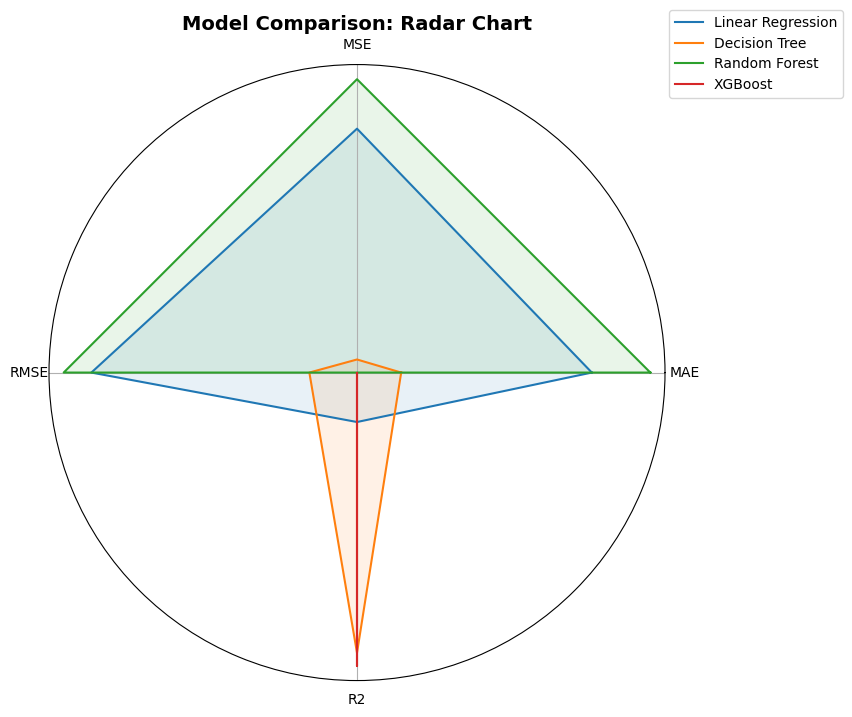

In [62]:
df = pd.DataFrame(model_results)

# Normalize metrics for better visualization (0-1 scale)
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
normalized_df = df.copy()
for metric in metrics:
    normalized_df[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in normalized_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Model Comparison: Radar Chart", fontsize=14, weight='bold')

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.savefig('img/model_comparison_radar_chart.png', dpi=300)  # Save to the output directory

plt.show()

C:\Users\negid\AppData\Local\Temp\ipykernel_10292\429031700.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
C:\Users\negid\AppData\Local\Temp\ipykernel_10292\429031700.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\negid\AppData\Local\Temp\ipykernel_10292\429031700.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
C:\Users\negid\AppData\Local\Temp\ipykernel_10292\429031700.py:14: UserWarning: set_ticklabels() should only be use

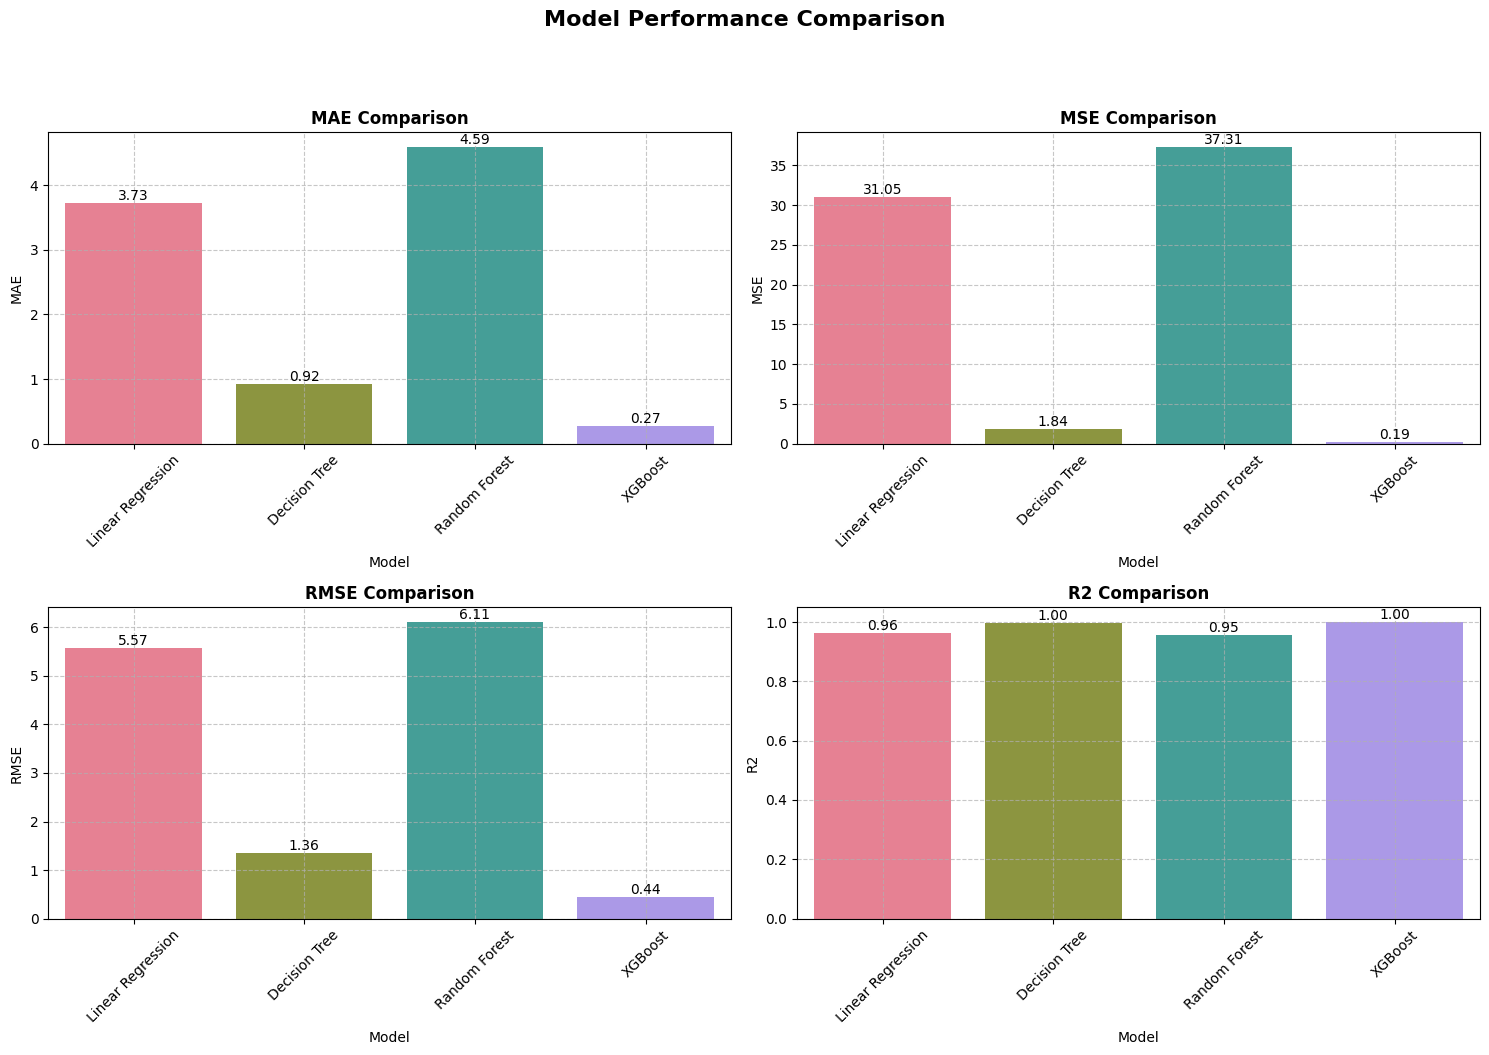

In [63]:
df = pd.DataFrame(model_results)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.05)

axes = axes.flatten()

metrics = ['MAE', 'MSE', 'RMSE', 'R2']
colors = sns.color_palette("husl", 4)

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for j, v in enumerate(df[metric]):
        ax.text(j, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/model_comparison_bar_chart.png', dpi=300)  # Save to the output directory

plt.show()

XGBoost clearly performed well here.
Do note that for RMSE, MSE, and MAE metrics, the lower the value the better, For R2, higher values indicate better benchmark.